In [8]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import copy
from importlib import reload
import matplotlib.pyplot as plt
import multiprocessing
from IPython.display import clear_output, display
import subprocess
import glob
from pathlib import Path
import os

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

cwd = Path(os.getcwd())

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

lamD_per_pix = 3.45e-6 / (fl * wavelength/fsm_pupil_diam) # lamD per pixel
print(lamD_per_pix)

as_per_pix = lamD_per_pix * as_per_lamD
print(as_per_pix)

v_zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

18.389524275269295 arcsec
0.08599262769878883
1.581363514561072 arcsec


In [9]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [12]:
npsf = 64
cam.set_roi(575, 900, npsf, client0)

In [11]:
cam.set_exptime(0.0001, client0)

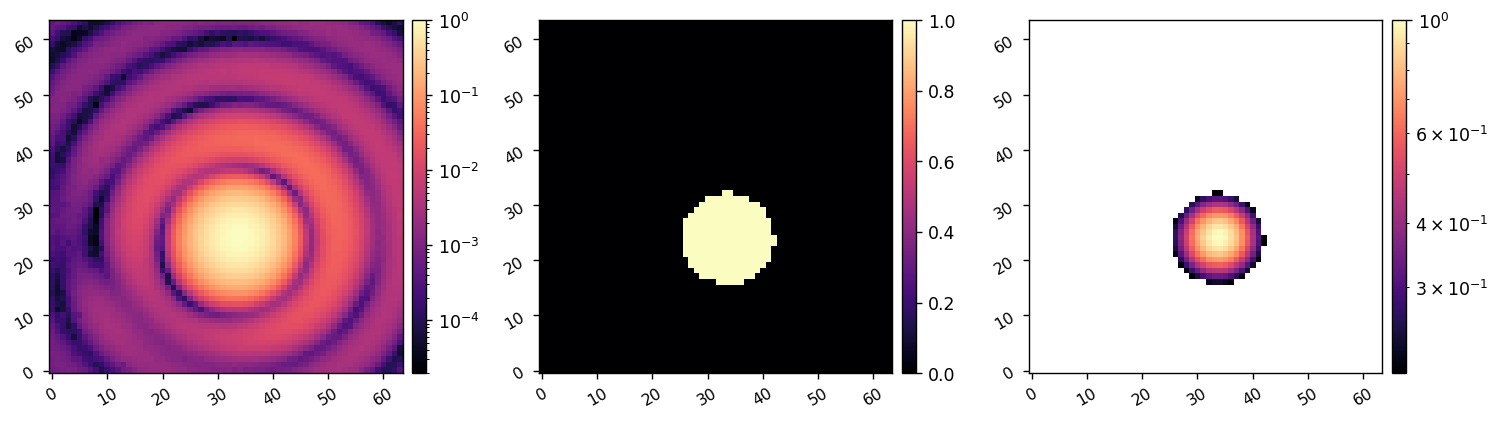

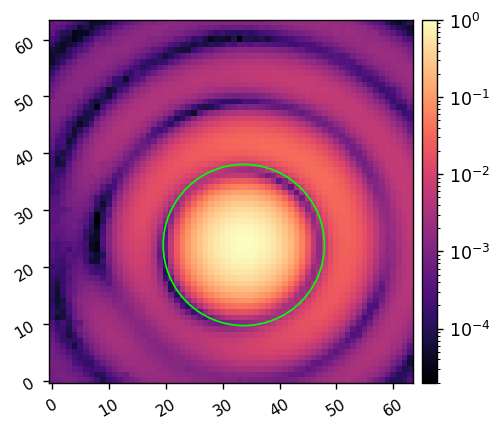

In [16]:
cam.Nframes = 1000
im = cam.snap()

reload(utils)
cen = utils.centroid(im, thresh=0.2, plot=True)
imshow1(im, lognorm=True, patches=[Circle(cen, 1.22/lamD_per_pix, fill=False, color='lime')])


# Setup FSM Interface

In [14]:
fsm_bias_channel = ImageStream('dm00disp00')
fsm_channel = ImageStream('dm00disp10')

In [65]:
fsm_bias_channel.write(v_bias)

In [64]:
fsm_bias_channel.write(v_zero)
fsm_channel.write(v_zero)

In [13]:
throt = 30*u.degree
Mrot = np.array([
    [np.cos(throt), -np.sin(throt)],
    [np.sin(throt), np.cos(throt)],
])

tt = np.array([0,1])

Mrot@tt

array([-0.5      ,  0.8660254])

# Take tip/tilt images and derive the coordinate transform required to get tip/tilt to actual match xy coordinates on the camera.

In [86]:
reload(fsm_utils)
amp = 5*u.arcsec

v_tip = fsm_utils.get_fsm_volts(tip=amp, tilt=0*u.arcsec)
v_tilt = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=amp)

print(v_tip)
print(v_tilt)

[[ 1.04965241]
 [-0.5248262 ]
 [-0.5248262 ]]
[[ 0.        ]
 [ 0.90902565]
 [-0.90902565]]


In [87]:
tsleep = 0.5
cam.Nframes = 100

fsm_channel.write(v_zero)
time.sleep(tsleep)
bias1_im = cam.snap()

fsm_channel.write(v_tip)
time.sleep(tsleep)
tip_im = cam.snap()

fsm_channel.write(v_zero)
time.sleep(tsleep)
bias2_im = cam.snap()

fsm_channel.write(v_tilt)
time.sleep(tsleep)
tilt_im = cam.snap()

fsm_channel.write(v_zero)

In [88]:
cthresh = 0.1

bias1_cen = utils.centroid(bias1_im, thresh=cthresh, plot=0)
bias2_cen = utils.centroid(bias2_im, thresh=cthresh, plot=0)
tip_cen = utils.centroid(tip_im, thresh=cthresh, plot=0)
tilt_cen = utils.centroid(tilt_im, thresh=cthresh, plot=0)

tip_diff = tip_cen - bias1_cen
tilt_diff = tilt_cen - bias2_cen

In [98]:
th_tip = -np.arctan2(tip_diff[1], tip_diff[0]) * 180*u.degree/np.pi + 90*u.degree
th_tilt = -np.arctan2(tilt_diff[1], tilt_diff[0]) * 180*u.degree/np.pi

print(th_tip)
print(th_tilt)

60.840725301552425 deg
60.02932634871597 deg


In [99]:
th = -(th_tip + th_tilt)/2
print(th)

-60.4350258251342 deg


# Retest with the measured rotation applied.

In [100]:
reload(fsm_utils)
amp = 5*u.arcsec

v_tip = fsm_utils.get_fsm_volts(tip=amp, tilt=0*u.arcsec, rot=th)
v_tilt = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=amp, rot=th)

print(v_tip)
print(v_tilt)

[[ 0.51790925]
 [-1.04962215]
 [ 0.53171291]]
[[ 0.91298422]
 [-0.00796955]
 [-0.90501468]]


In [101]:
tsleep = 0.5
cam.Nframes = 100

fsm_channel.write(v_zero)
time.sleep(tsleep)
bias1_im = cam.snap()

fsm_channel.write(v_tip)
time.sleep(tsleep)
tip_im = cam.snap()

fsm_channel.write(v_zero)
time.sleep(tsleep)
bias2_im = cam.snap()

fsm_channel.write(v_tilt)
time.sleep(tsleep)
tilt_im = cam.snap()

fsm_channel.write(v_zero)

In [104]:
cthresh = 0.1

bias1_cen = utils.centroid(bias1_im, thresh=cthresh, plot=0)
bias2_cen = utils.centroid(bias2_im, thresh=cthresh, plot=0)
tip_cen = utils.centroid(tip_im, thresh=cthresh, plot=0)
tilt_cen = utils.centroid(tilt_im, thresh=cthresh, plot=0)

tip_diff = tip_cen - bias1_cen
tilt_diff = tilt_cen - bias2_cen

print(tip_diff)
print(tilt_diff)

[-0.0634455   2.76119512]
[2.8076727 0.0476885]


In [103]:
th_tip = np.arctan2(tip_diff[1], tip_diff[0]) * 180*u.degree/np.pi
th_tilt = np.arctan2(tilt_diff[0], tilt_diff[1]) * 180*u.degree/np.pi

print(th_tip)
print(th_tilt)

91.31628502692944 deg
89.02692119188183 deg
